In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS

from numpy import array
import tensorflow as tf 
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>")

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_colwidth = 120

In [2]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
data = data[['id','text','target']]
data.columns = ['id','text','target']

test = test[['id','text']]
test.columns = ['id','text']

In [4]:
data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...,1
3,6,"13,000 people receive #wildfires evacuation orders in California",1
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### EDA

In [5]:
print("taille des datasets")
print(f" train : {data.shape}")
print(f" test : {test.shape}")

taille des datasets
 train : (7613, 3)
 test : (3263, 2)


In [6]:
print("Train set : pas de valeur Nan :")
print(data.isnull().sum())

print('')

print("Test set : pas de valeur Nan :")
print(test.isnull().sum())

Train set : pas de valeur Nan :
id        0
text      0
target    0
dtype: int64

Test set : pas de valeur Nan :
id      0
text    0
dtype: int64


In [7]:
print("Nombre de tweets Non Disaster -0- et Disaster -1- :")
data.target.value_counts()

Nombre de tweets Non Disaster -0- et Disaster -1- :


0    4342
1    3271
Name: target, dtype: int64

Non Disaster -0- et Disaster -1- :


/Users/berrehailmalika/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Nombre de tweets')

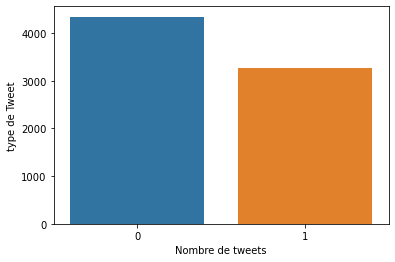

In [8]:
print('Non Disaster -0- et Disaster -1- :')

sns.countplot(data['target'])

plt.ylabel("type de Tweet")
plt.xlabel("Nombre de tweets")

### Data clean

In [9]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")


In [10]:
data["text_clean"] = data["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
data["text_clean"] = data["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
data["text_clean"] = data["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if token.lemma_ not in STOP_WORDS]))
data = data[['id','text_clean','target']]

test["text_clean"] = test["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
test["text_clean"] = test["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
test["text_clean"] = test["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if token.lemma_ not in STOP_WORDS]))
test = test[['id','text_clean']]



In [11]:
def wordcloud(df, column, title):
    words = ' '.join(df[column].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords=stopwords, width=512, height=512).generate(words)
    plt.figure(figsize=(50,8), frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

### Visualisation data

Importance mots : Disaster Tweets



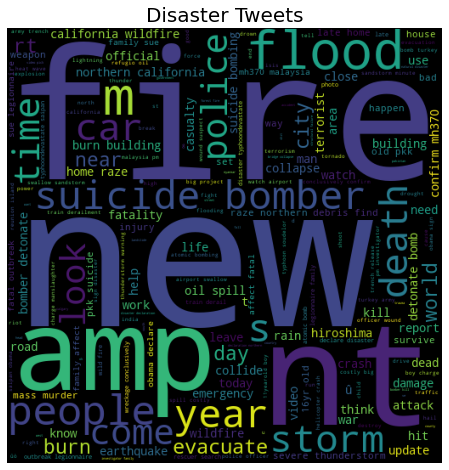

In [12]:
print("Importance mots : Disaster Tweets")
print('')
wordcloud(data[data["target"]==1], "text_clean", "Disaster Tweets")

Importance mots : No Disaster Tweets



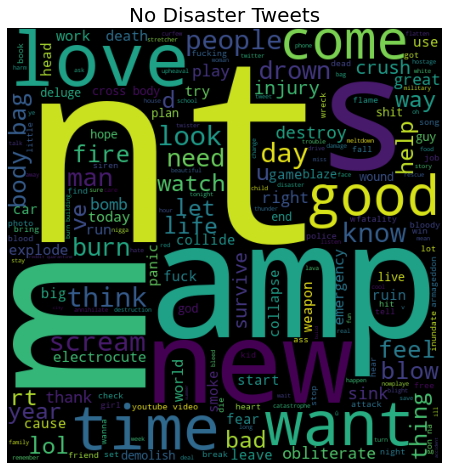

In [13]:
print("Importance mots : No Disaster Tweets")
print('')
wordcloud(data[data["target"]==0], "text_clean", "No Disaster Tweets")

### Topic Modelling

---- Sujets les plus traités ---- 
CLUSTER  -1


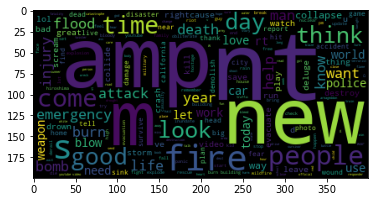

-----------
CLUSTER  1


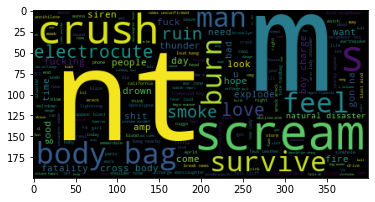

-----------
CLUSTER  18


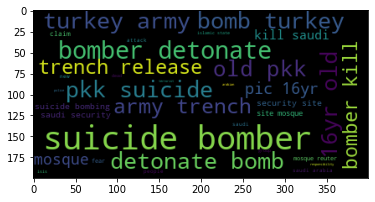

-----------
CLUSTER  52


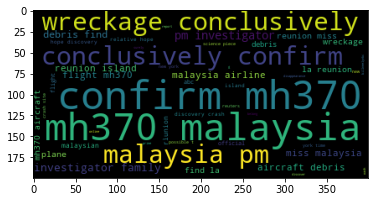

-----------
CLUSTER  133


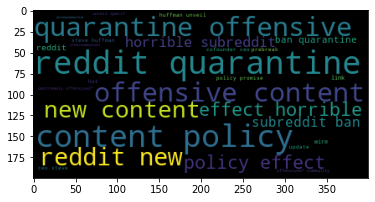

-----------
CLUSTER  50


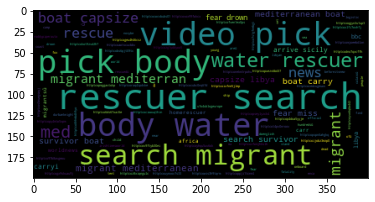

-----------
CLUSTER  130


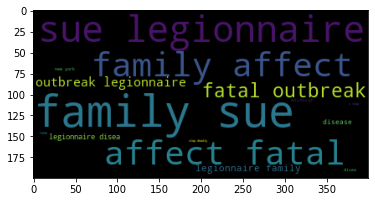

-----------
CLUSTER  27


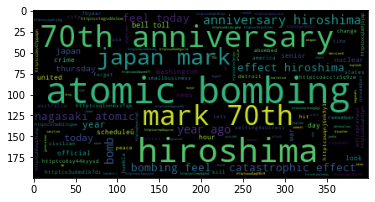

-----------
CLUSTER  96


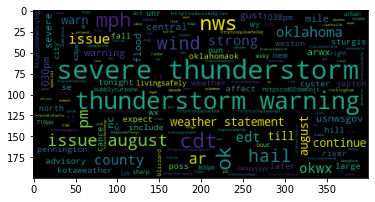

-----------
CLUSTER  3


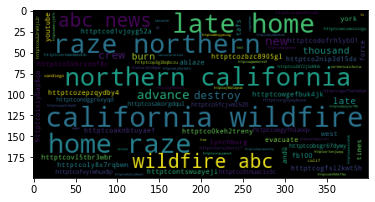

-----------


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import wordcloud
#from sklearn.decomposition import TruncatedSVD

print("---- Sujets les plus traités ---- ")

vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
X = vectorizer.fit_transform(data['text_clean'])
dense = X.toarray()

db_cluster = DBSCAN(eps=0.7, min_samples=4, metric="cosine", algorithm="brute")
db_cluster.fit(dense)

data['cluster'] = db_cluster.labels_

wd = wordcloud.WordCloud()
for c in data['cluster'].value_counts().index[:10] :
    print("CLUSTER ", c)
    texts = " ".join(data.loc[data['cluster']==c,'text_clean'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

In [15]:
# comparer si selon les keywords  la target est bien negative

### Data Preparation

In [16]:
tweets = data['text_clean'] 
target = data['target']

vocab_size = 19322

embedding_dim = 100

max_length = 100

trunc_type='post'

padding_type='post'

oov_tok = "<OOV>"

training_size = 20000

X_train, X_test, y_train, y_test = train_test_split(tweets, target, 
random_state=3, test_size=0.2)

In [17]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)

text_index = tokenizer.word_index

data_sequences = tokenizer.texts_to_sequences(X_train)

data_padded = pad_sequences(data_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)

test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

tst_sequences = tokenizer.texts_to_sequences(test["text_clean"])

tst_padded = pad_sequences(tst_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
training_data = np.array(data_padded)

training_labels = np.array(y_train)

eval_data = np.array(test_padded)

eval_labels = np.array(y_test)

tst_data = tst_padded

tst_labels = np.array(test["id"])

### Data NLP Preprocessing & Model

In [18]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1932200   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                2424      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 1,934,649
Trainable params: 1,934,649
Non-trainable params: 0
_________________________________________________________________


In [20]:

#stopping which stop training when a monitored metric has stopped improving

stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lrr = ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.5, min_lr=0.00001)

num_epochs = 15

history = model.fit(training_data, training_labels, epochs=num_epochs, validation_data=(eval_data, eval_labels), 
                 verbose=2, callbacks=[stopping, lrr])

Epoch 1/15
191/191 - 5s - loss: 0.6784 - accuracy: 0.5749 - val_loss: 0.6778 - val_accuracy: 0.5522
Epoch 2/15
191/191 - 3s - loss: 0.6287 - accuracy: 0.6530 - val_loss: 0.5864 - val_accuracy: 0.6756
Epoch 3/15
191/191 - 4s - loss: 0.4481 - accuracy: 0.8432 - val_loss: 0.4684 - val_accuracy: 0.7984
Epoch 4/15
191/191 - 4s - loss: 0.3220 - accuracy: 0.8768 - val_loss: 0.4595 - val_accuracy: 0.7945
Epoch 5/15
191/191 - 4s - loss: 0.2477 - accuracy: 0.9056 - val_loss: 0.4635 - val_accuracy: 0.8050
Epoch 6/15
191/191 - 3s - loss: 0.1921 - accuracy: 0.9271 - val_loss: 0.4814 - val_accuracy: 0.8063
Epoch 7/15
191/191 - 4s - loss: 0.1503 - accuracy: 0.9489 - val_loss: 0.5078 - val_accuracy: 0.7945

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


In [21]:
#num_epochs = 15

#history = model.fit(training_data, training_labels, epochs=num_epochs, validation_data=(eval_data, eval_labels), 
                 #verbose=2)

<Figure size 432x288 with 0 Axes>

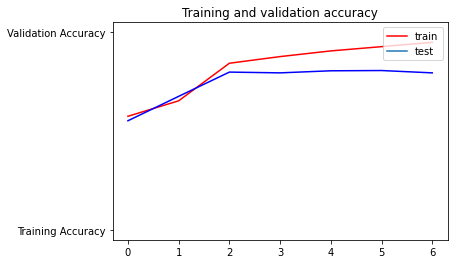

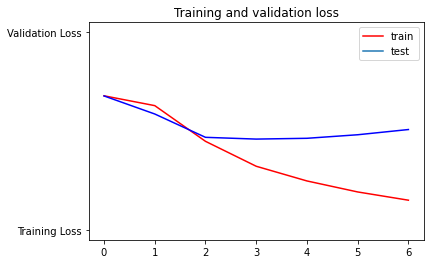

<Figure size 432x288 with 0 Axes>

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')

plt.title('Training and validation accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.title('Training and validation loss')
plt.figure()

In [23]:
predictions = model.predict(tst_data)

predictions = np.around(predictions)

predictions = predictions.astype(int)

predictions_tweets = pd.DataFrame()

predictions_tweets["id"] = test["id"]

predictions_tweets["target"] = predictions

predictions_tweets['target'] = predictions_tweets['target'].replace([0,1],['Non Disaster','Disaster'])


In [24]:
predictions_tweets["target"].value_counts()

Non Disaster    1884
Disaster        1379
Name: target, dtype: int64

In [25]:
print("exemple de tweet 'Disaster' : ")

Disaster_id = predictions_tweets[predictions_tweets.target == "Disaster"].sample(1)

Disaster = test[test.id == int(Disaster_id.id)]

print("")

print(Disaster['text_clean'].to_string(index=False))

exemple de tweet 'Disaster' : 

 watch airport swallow sandstorm minute httptco1oemjto9dp


In [26]:
print("exemple de tweet 'Non Disaster' :")

No_Disaster_id = predictions_tweets[predictions_tweets.target == "Non Disaster"].sample(1)
NO_Disaster = test[test.id == int(No_Disaster_id.id)]
print("")

print(NO_Disaster['text_clean'].to_string(index=False))


exemple de tweet 'Non Disaster' :

 I survive try destroy man boy
